In [160]:
import sys, os
import numpy as np
import netCDF4 as ncdf
import matplotlib.pylab as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from scipy import interpolate
import datetime as DT
from cbook2 import *

afile = "/Users/Louis.Wicker/FV3_ARW_FINAL/3km/quarter_ss/arw/wrfout_all.nc"
ffile = "/Users/Louis.Wicker/FV3_ARW_FINAL/3km/quarter_ss/fv3_alpha/fv3_history.nc"

ftime = 90
dx    = 3000.
grav  = 9.806
epsilon = 0.622

ihwidth  = int(15000. / dx)
jhwidth  = int(15000. / dx)

z_interp = 50. + 100.*np.arange(151)

color    = ['blue','red','green']
name     = ['FV3', 'ARW']

In [161]:
#===============================================================================

def plot_contour(fld, x = None, y = None, title = None, glat=None, glon=None,
                 clevels = None, ctable = None, zoom = None, scale = 1, ax = None, **kwargs):
    
    if x == None:
        x = scale*np.arange(fld.shape[1])

    if y == None:
        y = scale*np.arange(fld.shape[0])
        
    xx, yy = np.meshgrid(x, y)
        
    if title == None:
        title = 'FLD'

    if type(clevels) == type(None):
        amin, amax, cint = nice_mxmnintvl(fld.min(), fld.max(), outside=True, **kwargs)
        clevels = np.linspace(amin, amax, num=int(cint), endpoint=True)
                
    if ctable == None:
        ctable = 'bwr'
        
    if ax == None:
        plot = plt.contourf(xx, yy, fld, clevels, cmap = ctable)
        plot = plt.contour(x, y,  fld, clevels[::2], colors='k', linewidths=0.5)
    else:
        plot = ax.contourf(xx, yy, fld, clevels, cmap = ctable)
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(plot, cax=cax, orientation='vertical')

        plot = ax.contour(x, y,  fld, clevels[::2], colors='k', linewidths=0.5)

        ax.set_aspect('equal', 'datalim')
        ax.set_title(title, fontsize=10)

        if zoom:
            dx = xx.max() - xx.min()
            dy = yy.max() - yy.min()
            ax.set_xlim(xx.min() + dx*zoom[0],xx.min()+dx*zoom[1])
            ax.set_ylim(yy.min() + dy*zoom[2],yy.min()+dy*zoom[3])
            
        at = AnchoredText("Max: %4.1f \n Min: %4.1f" % (fld.max(),fld.min()),
                          loc=4, prop=dict(size=20), frameon=True,)
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")

        ax.add_artist(at)
        


    
# get coordinates for contour plots

#     cbar    = plt.colorbar(plot,location='right',pad="5%")
#     cbar.set_label(title)
#     plot    = plt.contour(x, y,  fld, clevel[::2], colors='k', linewidths=0.5)




In [181]:
#---------------------------------
print('\n ----ARW----\n')
step = int(ftime / 5)

f  = ncdf.Dataset(afile, "r")

phistag = (f.variables['PH'][step,:,:,:]+f.variables['PHB'][step,:,:,:])
print(phistag.shape)
dphi    = (phistag[1:]-phistag[:-1])
print(dphi.shape, dphi.max()/grav, dphi.min()/grav)

mu = (f.variables['MU'][step,:,:]+f.variables['MUB'][step,:,:])
dn = f.variables['DNW'][step]

print(mu.shape, mu.max(), mu.min())
print(dn.shape, dn.max(), dn.min())

nz, ny, nx = dphi.shape

den = - mu[np.newaxis,:,:] * dn[:,np.newaxis,np.newaxis] / dphi  # new dry density

print(den.shape, den.max(), den.min())


pbar = f.variables['PB'][0,:,:,:]
qbar = f.variables['QVAPOR'][0,:,:,:]
pi0  = (1.0e5/pbar)**0.285
p    = f.variables['P'][step,:,:,:] + pbar
pi   = (1.0e5/p)**0.285
pp   = (p - pbar) / 100.
psfc = (f.variables['PSFC'][step,:,:] - pbar[0,0,0])/100.

theta= (f.variables['T'][step,:,:,:]+300.) / pi
qv   = f.variables['QVAPOR'][step,:,:,:]
qcond= f.variables['QCLOUD'][step,:,:,:]+f.variables['QRAIN'][step,:,:,:]+ \
       f.variables['QSNOW'][step,:,:,:]++f.variables['QGRAUP'][step,:,:,:]

temp_d= theta / pi

print("P:     ",p.max(), p.min())
print("pertP: ",pp.max(), pp.min())
print("PI:    ",pi.max(), pi.min())
print("PI0:   ",pi.max(), pi.min())

print("Temp of dry air: ",temp_d.max(), temp_d.min())

temp_m = temp_d * (1.0 + qv/epsilon) / (1 + qv + qcond)
print("Temp of moist air: ",temp_m.max(), temp_m.min())

p_m = den * 287.04 * temp_m
print("P_moist: ",p_m.max(), p_m.min())

pert_p_m = (p_m - pbar) / 100.

print("pertP: ",pp[1].max(), pp[1].min())
print("pertP moist ",pert_p_m[1].max(), pert_p_m[1].min())


wstag  = f.variables['W'][step,:,:,:]
w      = (wstag[:-1]+wstag[1:])/2

# wloc = np.unravel_index(np.argmax(w.max(axis=0), axis=None), w.shape[1:])
# wloc = np.array(wloc)


 ----ARW----

(52, 100, 100)
(51, 100, 100) 2104.773225576178 17.02110917622183
(100, 100) 98602.31 97404.22
(51,) -0.0019999743 -0.050000012
(51, 100, 100) 1.1811894 0.022308758
P:      100344.88 1434.5103
pertP:  4.4384375 -6.1259766
PI:     3.3522737 0.99901927
PI0:    3.3522737 0.99901927
Temp of dry air:  300.51013 65.933205
Temp of moist air:  303.1362 65.957886
P_moist:  98840.6 429.01566
pertP:  4.3660154 -2.7503905
pertP moist  -11.155391 -19.056719


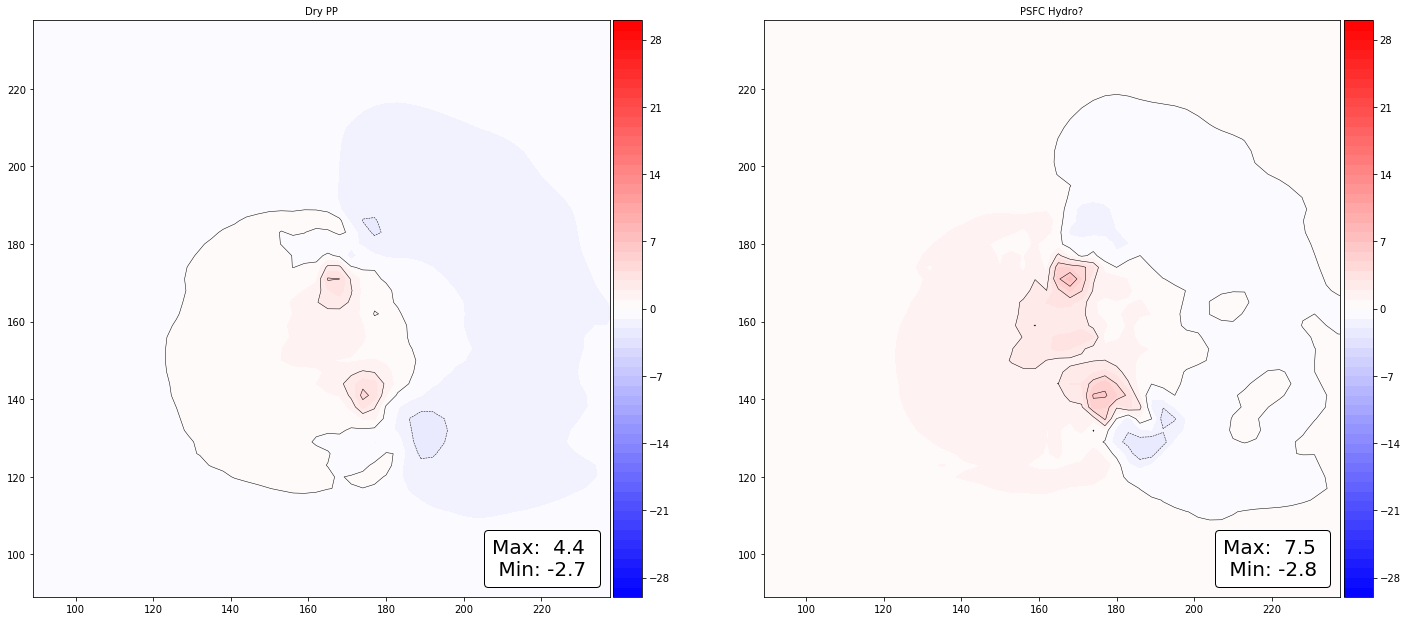

In [182]:
fig, (ax1, ax2) =  plt.subplots(1, 2, figsize=(24,12))

p_clev = np.arange(-30.,31.,1.)

plot_contour(pp[0,:,:], title = "Dry PP", ax = ax1, scale=3, clevels = p_clev, ctable='bwr', cint=0., zoom=[0.3,0.8,0.3,0.8])
#plot_contour(pert_p_m[0,:,:], title = "Moist PP", ax = ax2, scale=3, clevels = p_clev, ctable='bwr', cint=0., zoom=[0.3,0.8,0.3,0.8])
plot_contour(psfc, title = "PSFC Hydro?", ax = ax2, scale=3, clevels = p_clev, ctable='bwr', cint=0., zoom=[0.3,0.8,0.3,0.8])

plt.show()


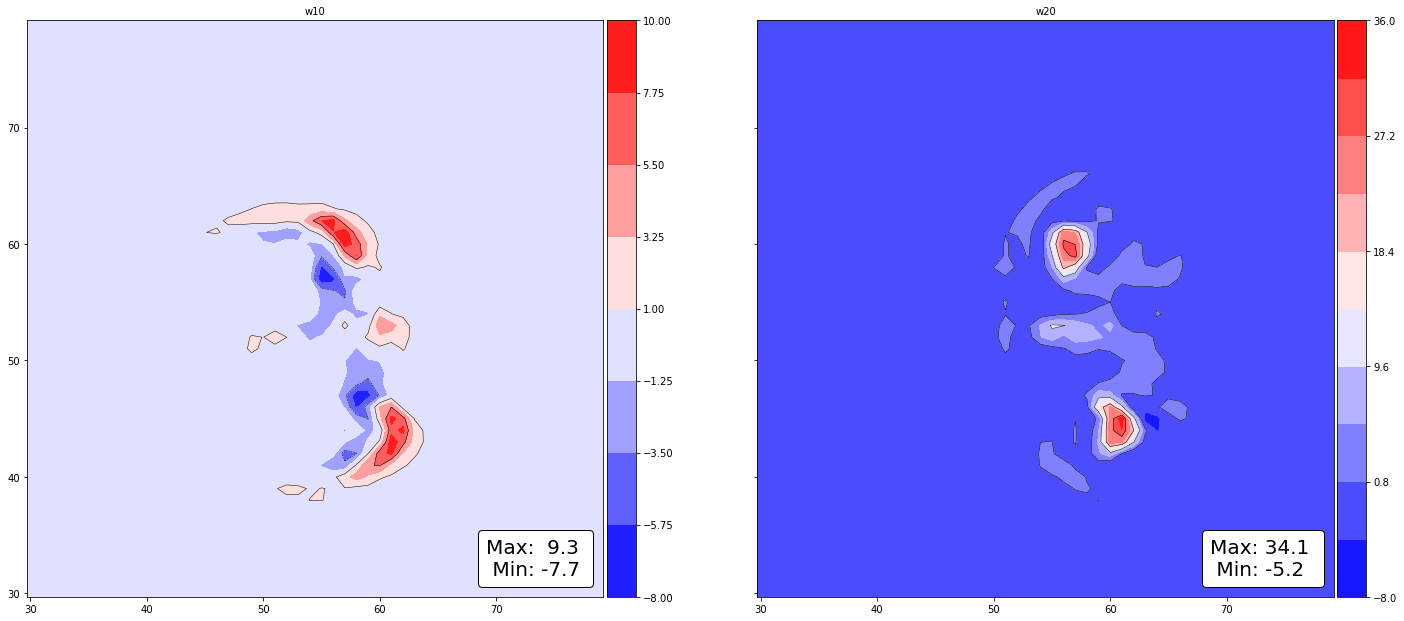

In [164]:
fig, (ax1, ax2) =  plt.subplots(1, 2, sharey=True, figsize=(24,12))

plot_contour(w[10,:,:], title = "w10", ax = ax1, ctable='bwr', cint=0., zoom=[0.3,0.8,0.3,0.8])
plot_contour(w[20,:,:], title = "w20", ax = ax2, ctable='bwr', cint=0., zoom=[0.3,0.8,0.3,0.8])
plt.show()


 ----FV3W----



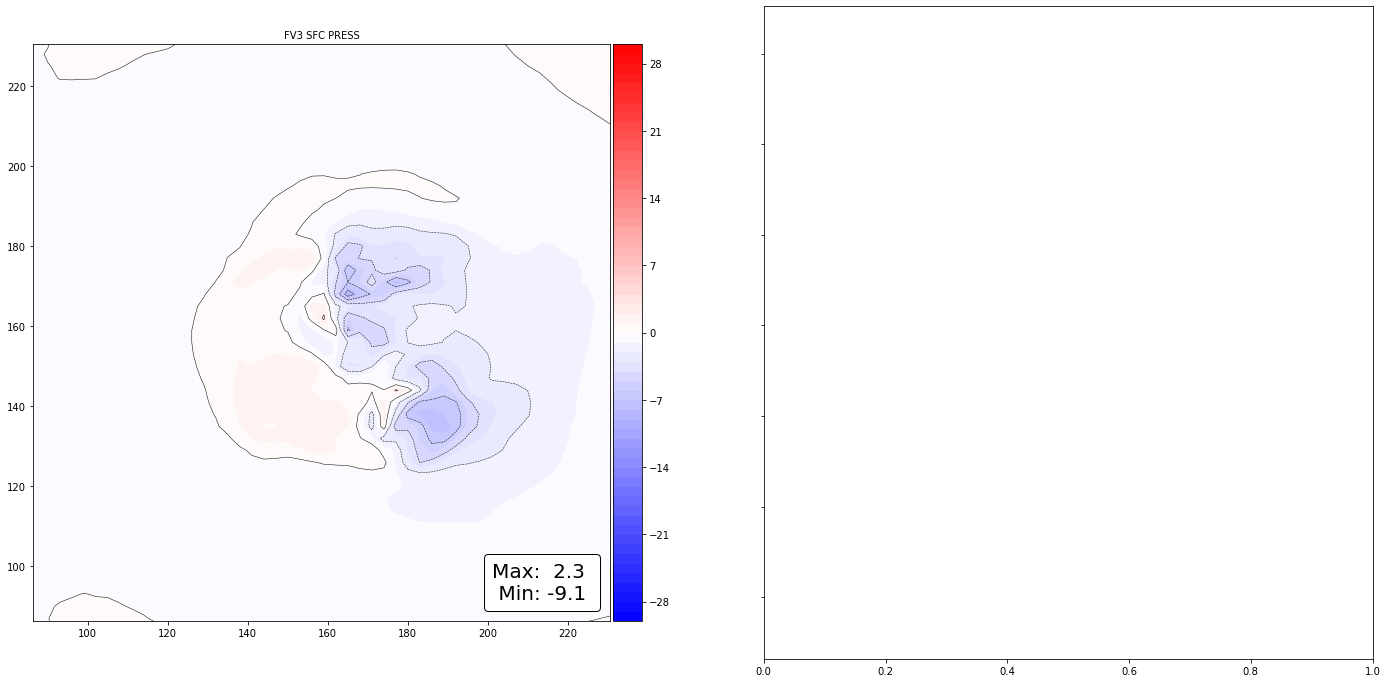

In [167]:
f.close()
#---------------------------------
print('\n ----FV3W----\n')

f = ncdf.Dataset(ffile, "r")

psfc    = (f.variables['pressfc'][step,:,:] - 100000.) / 100.

fig, (ax1, ax2) =  plt.subplots(1, 2, sharey=True, figsize=(24,12))
plot_contour(psfc, title = "FV3 SFC PRESS", ax = ax1, scale=3, clevels = p_clev, ctable='bwr', cint=0., zoom=[0.3,0.8,0.3,0.8])

plt.show()
